In [1]:
import os
import time
import random
import torch
import mrcfile
import tifffile
import numpy as np
from torch import nn
from math import ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch import FloatTensor as FT
from torch.autograd import Variable as V
from concurrent.futures import ThreadPoolExecutor
from utils import *
from matplotlib.colors import ListedColormap
rawData = "/home/tyche/paddle_SN2N/raw_data/"
Datasets = "/home/tyche/paddle_SN2N/datasets/"


def get_all_files(directory):
    file_list = list()
    n_files = 0
    for file in os.listdir(directory):
        file_list.append(f"{directory}/{file}")
        n_files += 1
    return file_list, n_files


import torch
print(torch.__version__)
print(torch.version.cuda)

2.7.0+cu126
12.6


In [2]:
def split_by_index(arr):
    groups = {}
    for row in arr:
        key = row[0]
        if key not in groups:
            groups[key] = []
        groups[key].append(row)
    
    # 转换为NumPy数组
    for key in groups:
        groups[key] = np.array(groups[key])
    
    return groups
arr = np.array([
    [1, 2, 3],
    [1, 4, 5],
    [2, 6, 7],
    [2, 8, 9],
    [3, 10, 11]
])

# 示例
groups_dict = split_by_index(arr)
for key, group in groups_dict.items():
    print(f"index {key}:")
    print(group)
    print()

def get_map_from_predictions():
    # chunk_files = [os.path.join('./predictions', f) for f in os.listdir('./predictions') if f.endswith('.npz')]
    chunk_files = [os.path.join('./datasets', f) for f in os.listdir('./datasets') if f.endswith('.npz')]
    chunk_positions = [os.path.splitext(os.path.basename(f))[0].split("_") for f in chunk_files]
    chunk_positions = np.array(chunk_positions, dtype=int)
    groups = split_by_index(chunk_positions)

    
    # for chunk_file, chunk_position in zip(chunk_files, chunk_positions):
     
    




index 1:
[[1 2 3]
 [1 4 5]]

index 2:
[[2 6 7]
 [2 8 9]]

index 3:
[[ 3 10 11]]



In [3]:
kernel = torch.tensor([[[[0, 1], [1, 1]], [[1, 1], [1, 1]]],
                       [[[1, 0], [1, 1]], [[1, 1], [1, 1]]],
                       [[[1, 1], [0, 1]], [[1, 1], [1, 1]]],
                       [[[1, 1], [1, 0]], [[1, 1], [1, 1]]],
                       [[[1, 1], [1, 1]], [[0, 1], [1, 1]]],
                       [[[1, 1], [1, 1]], [[1, 0], [1, 1]]],
                       [[[1, 1], [1, 1]], [[1, 1], [0, 1]]],
                       [[[1, 1], [1, 1]], [[1, 1], [1, 0]]],])
kernel = torch.tensor([[[[1, 0], [0, 1]], [[0, 1], [1, 0]]],  
                       [[[0, 1], [1, 0]], [[1, 0], [0, 1]]]]).float()
kernel.shape

torch.Size([2, 2, 2, 2])

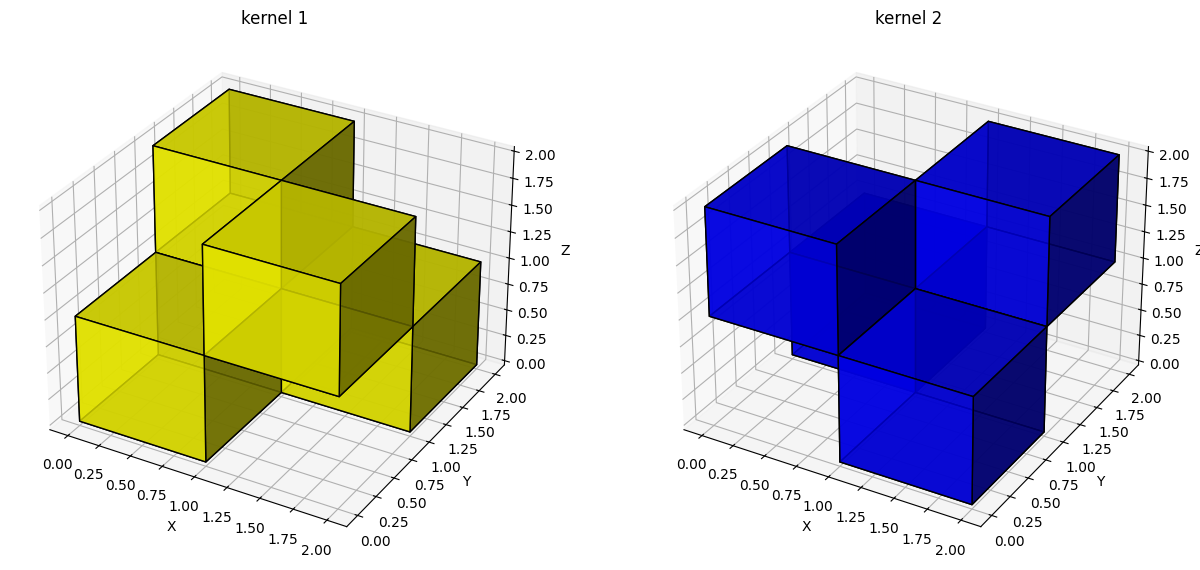

In [4]:
data = np.random.choice([0, 1], size=(5, 5, 5))
colors = ['yellow', 'blue', 'green', 'red', 'purple']
cmap = ListedColormap(colors)
fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i in range(min(8, kernel.shape[0])):  # 最多显示6个子图
    ax = axes[i]
    ax.voxels(kernel[i], facecolors=cmap(i%len(colors)), edgecolor='k', alpha=0.8)
    ax.set_title(f'kernel {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
plt.show()

In [5]:
x = torch.randn(1, 1, 5, 5)  # 输入张量 [批次大小, 通道数, 高度, 宽度]

kernel = torch.tensor([[[[1, 0], [0, 1]], [[0, 1], [1, 0]]], 
                       [[[0, 1], [1, 0]], [[1, 0], [0, 1]]]])

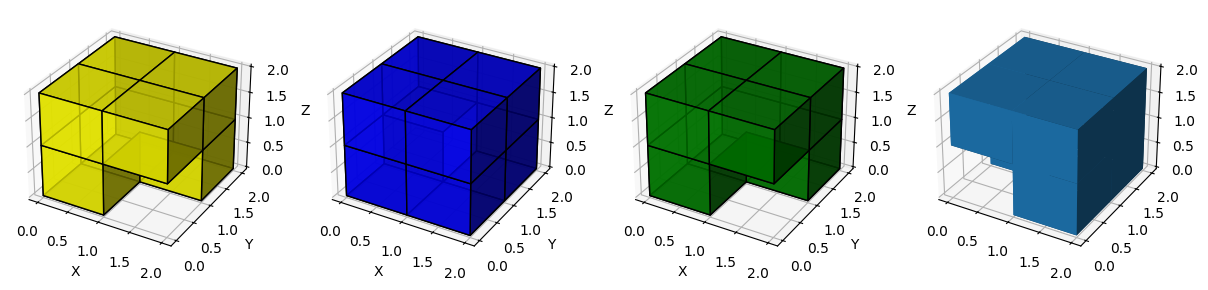

tensor([[[1, 5],
         [3, 7]],

        [[0, 4],
         [2, 6]]])

In [6]:
x = torch.arange(8).view(2, 2, 2)
dims = [[0, 1], [1, 2], [0, 2]]
fig, axes = plt.subplots(1, 4, figsize=(15, 10), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i in range(3):  
    ax = axes[i]
    ax.voxels(torch.rot90(x, 1, dims[i]), facecolors=cmap(i%len(colors)), edgecolor='k', alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
axes[3].voxels(x)
plt.show()
torch.rot90(x, 1, [0, 2])


In [7]:
import imageio

def combine_tensors_to_gif(
    tensors,
    titles,
    output_path: str = "combined_tensors.gif",
    fps: int = 2,
    cmap: str = "viridis",
    figsize: tuple = (12, 8),
    dpi: int = 100,
    show_colorbar: bool = True,
    vmin = 0,
    vmax = 255
):

    # Check all tensors have the same depth
    depths = [tensor.shape[0] for tensor in tensors]
    depth = max(depths)
    
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Generate frames for GIF
    frames = []
    
    for i in range(depth):
        # Create figure and axes
        fig, axes = plt.subplots(1, len(tensors), figsize=figsize, dpi=dpi, sharey=True)
        if len(tensors) == 1:
            axes = [axes]  # Ensure axes is always a list
        
        # Plot each tensor's current layer
        ims = []
        for j, tensor in enumerate(tensors):
            im = axes[j].imshow(tensor[i, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
            ims.append(im)
            axes[j].set_title(f"{titles[j]}_Layer_{i}")
        
        # Add colorbar if specified
        if show_colorbar:
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(ims[0], cax=cbar_ax)
        
        # Render figure to numpy array
        plt.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        # Close figure to free memory
        plt.close(fig)
    
    # Save frames as GIF
    imageio.mimsave(output_path, frames, fps=fps, loop=0)
    print(f"GIF saved to: {output_path}")

# Example usage
if __name__ == "__main__":
    # Create sample 3D tensors
    tensor1 = np.random.rand(10, 50, 50)  # 10 layers, 50x50 each
    tensor2 = np.random.rand(10, 50, 50)  # 10 layers, 50x50 each
    
    # Add structure to tensors for better visualization
    for i in range(10):
        x, y = np.ogrid[-i:50-i, -i:50-i]
        mask = x*x + y*y <= (25-i)**2
        tensor1[i][mask] = 2 * tensor1[i][mask]
        tensor2[i][mask] = 3 * tensor2[i][mask]
    
    # Create a sphere tensor
    sphere = np.zeros((10, 50, 50))
    for z in range(10):
        for y in range(50):
            for x in range(50):
                if (x-25)**2 + (y-25)**2 + (z-4)**2 <= 40:
                    sphere[z, y, x] = 1.0
    
    # Save all tensors to a single GIF
    combine_tensors_to_gif(
        tensors=[tensor1,
            tensor2,
            sphere],
        titles=['t1', 't2', 't3'],
        output_path="combined_tensors.gif",
        fps=24,
        cmap="viridis"
    )   

/tmp/ipykernel_19152/91390768.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_19152/91390768.py:50: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to: combined_tensors.gif


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import Dict, Optional
import os

def combine_tensors_to_gif(
    tensors: Dict[str, np.ndarray],
    output_path: str = "combined_tensors.gif",
    fps: int = 2,
    cmap: str = "viridis",
    figsize: tuple = (12, 8),
    dpi: int = 100,
    show_colorbar: bool = True,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None
) -> None:

    # Check all tensors have the same depth
    depths = [tensor.shape[0] for tensor in tensors.values()]   
    depth = max(depths)
    
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Generate frames for GIF
    frames = []
    
    for i in range(depth):
        # Create figure and axes
        fig, axes = plt.subplots(1, len(tensors), figsize=figsize, dpi=dpi, sharey=True)
        if len(tensors) == 1:
            axes = [axes]  # Ensure axes is always a list
        
        # Plot each tensor's current layer
        ims = []
        for j, (name, tensor) in enumerate(tensors.items()):
            im = axes[j].imshow(tensor[i % tensor.shape[0]], cmap=cmap, vmin=vmin, vmax=vmax)
            ims.append(im)
            axes[j].set_title(f"{name} - Layer {i % tensor.shape[0]}")
        
        # Add colorbar if specified
        if show_colorbar:
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(ims[0], cax=cbar_ax)
        
        # Render figure to numpy array
        plt.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        # Close figure to free memory
        plt.close(fig)
    
    # Save frames as GIF
    imageio.mimsave(output_path, frames, fps=fps, loop=0)
    print(f"GIF saved to: {output_path}")

# Example usage
if __name__ == "__main__":
    tensor1 = np.asarray(tifffile.imread('c12_SR_w1L-561_t1.tif'))
    maximum = np.percentile(tensor1[tensor1 > 0], 99.999)
    tensor1 = tensor1.clip(min=0.0, max=maximum) / maximum
    tensor2 = np.asarray(tifffile.imread('c12_SR_w1L-561_t1.tif'))
    maximum = np.percentile(tensor2[tensor2 > 0], 99.999)
    tensor2 = tensor2.clip(min=0.0, max=maximum) / maximum
    combine_tensors_to_gif(
        tensors={
            "Tensor 1": tensor1,
            "Tensor 2": tensor2,
        },
        output_path="combined_tensors.gif",
        fps=24,
        cmap="viridis"
    )    

FileNotFoundError: [Errno 2] No such file or directory: '/home/tyche/paddle_SN2N/c12_SR_w1L-561_t1.tif'

In [ ]:
axes_options = random.choice([(0, 1), (1, 2), (0, 2)])
axes_options

NameError: name 'random' is not defined